# Introduction to quantum programming

### First, let's make the cells wider :) 

In [174]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Let's check our qiskit version

In [118]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

## Let's import the necessary packages

In [119]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

from qiskit.test.mock import FakeLima

import mthree

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('ibmq-dark')
plt.style.use('ibmq-dark')
%config InlineBackend.figure_format='retina'

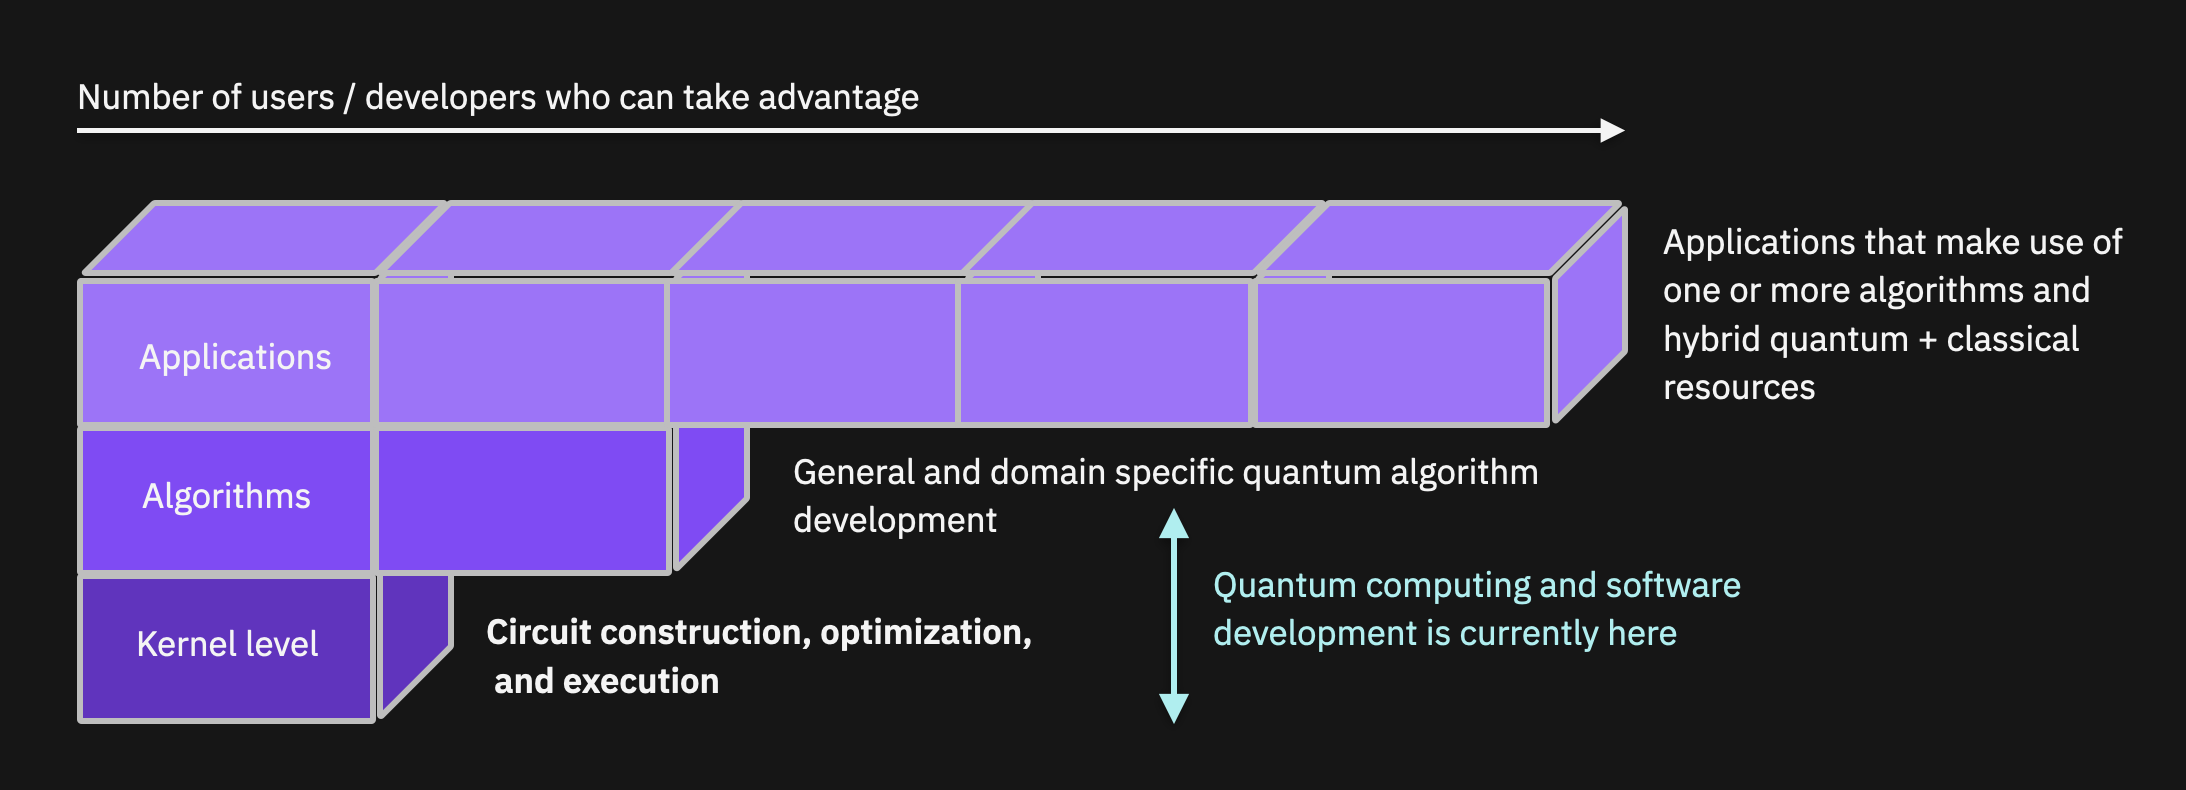

## Build quantum circuits

Let's begin by constructing a relatively simple circuit: a Bernstein-Vazirani circuit that recovers a "hidden" bit-string in a single query (as opposed to N queries classically).

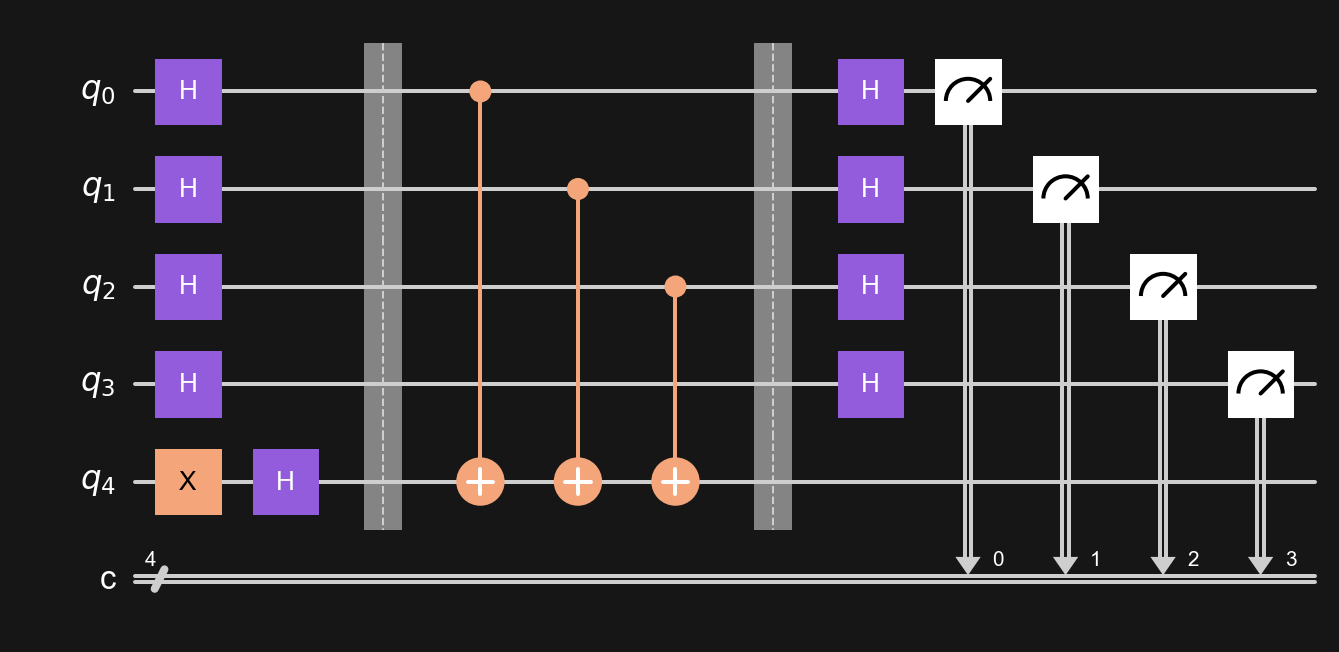

In [175]:
# Set the integer value that will be converted to a bit-string.
integer = 7
# Convert the integer to a bit-string.
bitstring = bin(integer)[2:]
# Specify the number of qubits you want to use for the bit-string.
num_qubits = 4

# Build the circuit.
qc = QuantumCircuit(num_qubits+1, num_qubits)

# Prepare the initial superposition state.
qc.x(num_qubits)
qc.h(range(num_qubits+1))
qc.barrier()

# For each value of '1' in the bit-string, place a CNOT gate that is controlled by the qubit at that index.
for idx, bit in enumerate(bitstring[::-1]):
    if int(bit):
        qc.cx(idx, num_qubits)
qc.barrier()

# Rotate the qubits back into the original basis for measurement.
qc.h(range(num_qubits))
# Record the states of the qubits.
qc.measure(range(num_qubits), range(num_qubits))
qc.draw('mpl')

When possible, always simulate your circuits first to verify that they do what they should.

In [176]:
# Set the simulator.
sim = Aer.get_backend('aer_simulator')

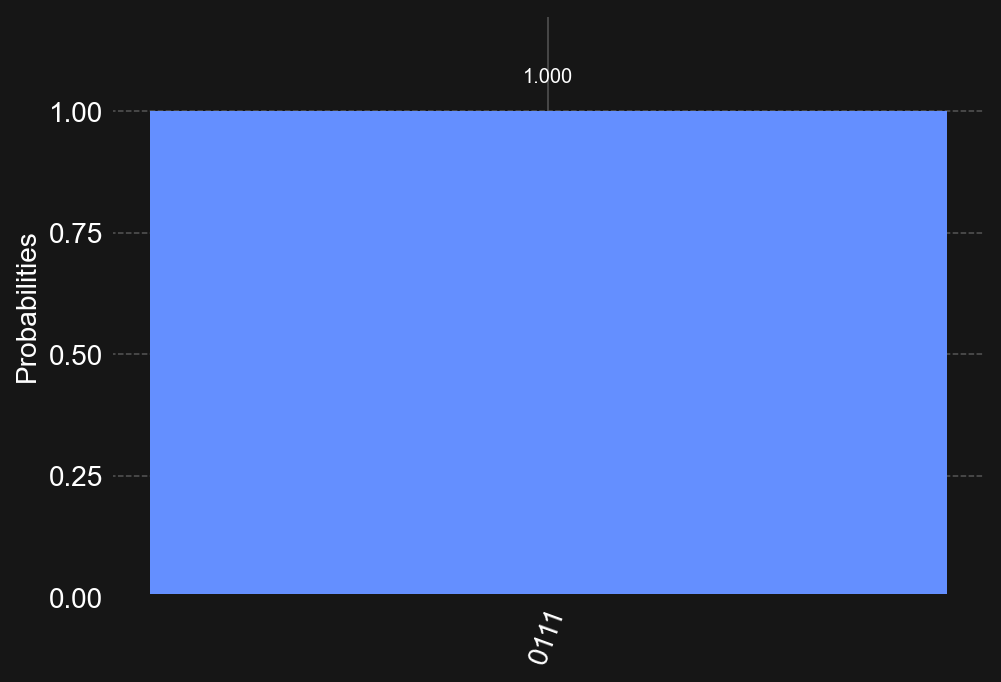

In [177]:
# Run the circuit and plot the result. 
counts = sim.run(qc, shots=10000).result().get_counts()
plot_histogram(counts)

The result is that the state of the qubits is found 100% of the time to be `0111`.  Let's check whether this measures the input integer (7).

In [178]:
int(list(counts.keys())[0], 2)

7

## Run on a real quantum system

In [125]:
IBMQ.load_account()

In [126]:
provider = IBMQ.get_provider(group='deployed')

In [179]:
#backend = provider.get_backend('ibmq_lima')
backend = FakeLima()
backend

<FakeLima('fake_lima')>

In general, it is not possible to run a circuit on a quantum computer the way you write it down initially.  There are a variety of transformations that must happen before the quantum computer can execute it.  These conversion steps are called transpiling:

In [180]:
# Take original circuit and convert it to one that will run on a target backend.
trans_qc = transpile(qc, backend)

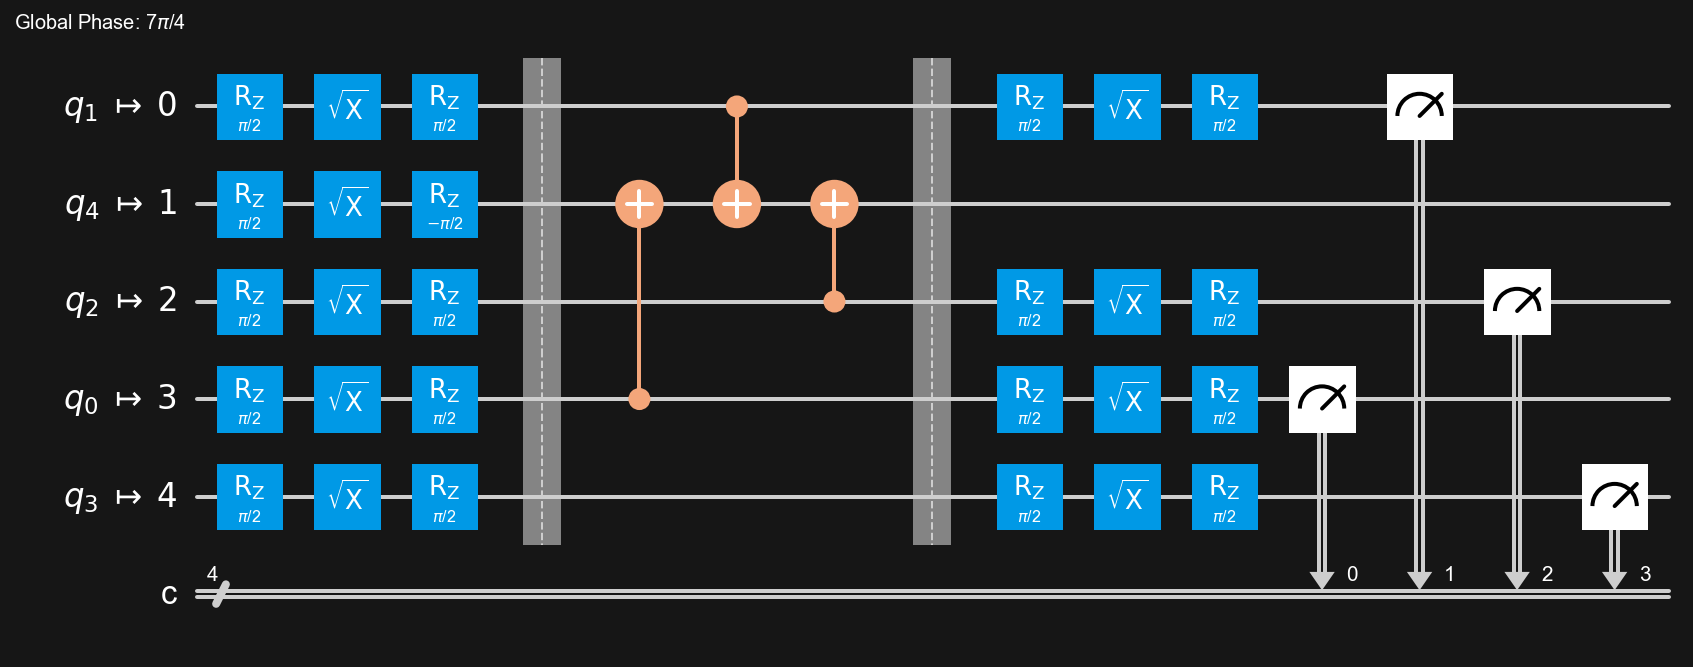

In [181]:
trans_qc.draw('mpl')

In [182]:
real_counts = backend.run(trans_qc, shots=10000).result().get_counts()

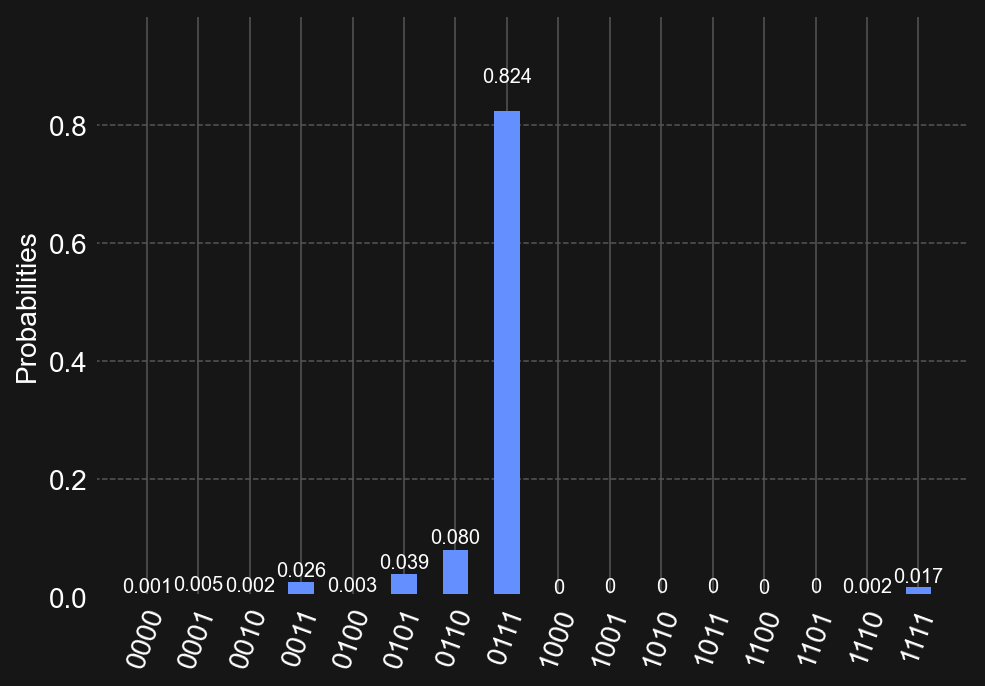

In [183]:
plot_histogram(real_counts)

## Clean up the noise

As we have seen, there is noise on present day quantum processors that cannot be corrected.  However, we can suppress the noise to some extent and even mitigate it to a large extent if we are willing to spend an exponential amount of resources to do so.

The simple circuit above is affected in large part by measurement errors, so let's clean those up a bit:

In [184]:
# Construct a mitigator that attempts to undo the measurement errors on the qubits our circuit uses.
mit = mthree.M3Mitigation(backend)
qubits = mthree.utils.final_measurement_mapping(trans_qc)
# Perform the calibration step
mit.cals_from_system(qubits)

Here is where we apply the correction and recover a distribution of results that is more accurate, but necessarily less precise (the 'no free lunch' theorem).

In [185]:
quasi_distribution = mit.apply_correction(real_counts, qubits)

We can now plot the new results against the raw results obtained earlier:

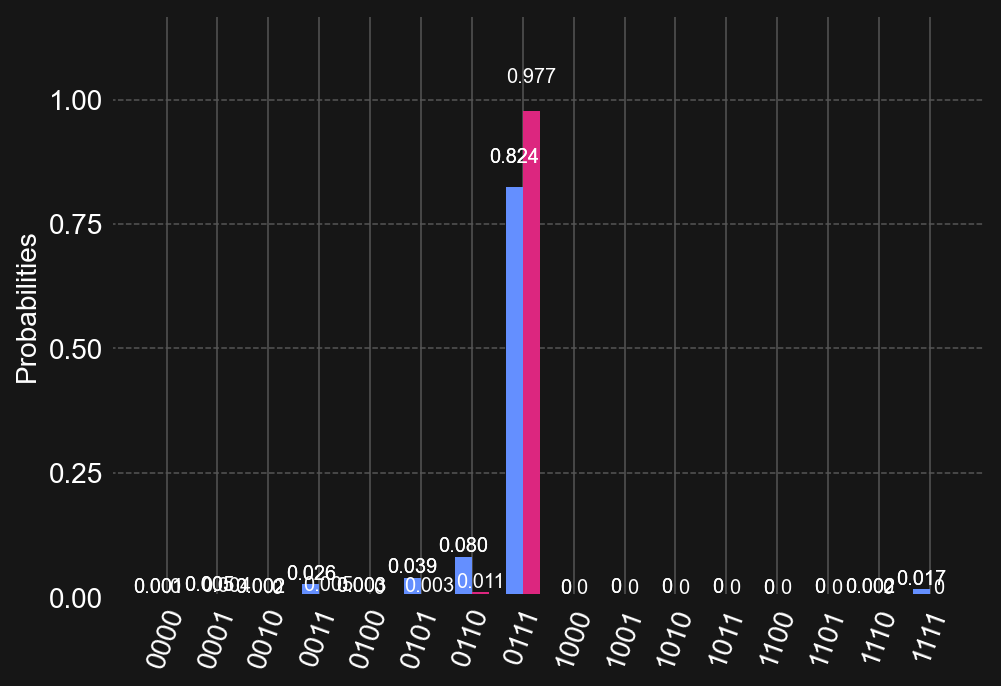

In [186]:
plot_histogram([real_counts, quasi_distribution.nearest_probability_distribution()])

## Qiskit IBM Runtime package

To install the package run this command:

`pip install qiskit-ibm-runtime`

There are three key items we will be using: the service itself, the quasiprobability sampler primitive (`Sampler`), and the expectation value estimator primitive (`Estimator`).

In [135]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator

First, save your Runtime account credentials if you have not done so already:

```python
QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
```

The `channel` keyword argument lets the Runtime know you are using the regular IBM Quantum access channel.  The other option is  IBM Cloud `channel='ibm_cloud'`.

In [187]:
service = QiskitRuntimeService(channel='ibm_quantum')

The service automatically allows for access to all backends that you can access.  To view them, run the following command:

In [188]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_armonk')>,
 <IBMBackend('ibmq_montreal')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibm_hanoi')>,
 <IBMBackend('ibmq_brooklyn')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibm_auckland')>,
 <IBMBackend('ibm_wellington')>,
 <IBMBackend('ibm_ithaca')>,
 <IBMBackend('ibm_peekskill')>,
 <IBMBackend('ibmq_toronto')>,
 <IBMBackend('ibmq_bogota')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_guadalupe')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_washington')>,
 <IBMBackend('alt_montreal')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('simulator_qasm3')>,
 <IBMBackend('ibmq_santiago')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>]

We can also query the available programs offered by the Runtime service:

In [189]:
service.pprint_programs()

hello-world:
  Name: hello-world
  Description: A sample runtime program.
qaoa:
  Name: qaoa
  Description: Qiskit Runtime QAOA program
torch-train:
  Name: torch-train
  Description: A runtime program to train hybrid QNN models with Pytorch.
torch-infer:
  Name: torch-infer
  Description: A runtime program to run inference and calculate the scores of Hybrid QNN models with Pytorch.
qasm3-runner:
  Name: qasm3-runner
  Description: A runtime program that takes one or more circuits, converts them to OpenQASM3, compiles them, executes them, and optionally applies measurement error mitigation. This program can also take and execute one or more OpenQASM3 strings. Note that this program can only run on a backend that supports OpenQASM3.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.
sample-expval:
  Name: sample-expval
  Description: A sample e

We can now choose one of the programs and view more information, including the parameters it takes and what it returns.

In [190]:
print(service.program('sampler'))

sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
  Creation date: 2021-10-26T14:41:57Z
  Update date: 2022-05-11T14:35:23.860989Z
  Max execution time: 10000
  Backend requirements:
    none
  Input parameters:
    Properties:
        - circuit_indices:
            Description: Indices of the circuits to evaluate.
            Type: array
            Required: True
        - circuits:
            Description: A single or list of QuantumCircuits.
            Type: ['array', 'object']
            Required: True
        - parameter_values:
            Description: A list of concrete parameters to be bound for each circuit. If specified, it must have the same length as circuit_indices.
            Type: array
            Required: False
        - parameters:
            Description: Parameters of the quantum circuits.
            Type: array
            Required: False
        - run_options:
            Description: A collection of key-valu

We will use a simulator and a real device and compare them.

In [140]:
backend_exp = service.backend('ibmq_kolkata')
backend_sim = service.backend('ibmq_qasm_simulator')

## How to use Qiskit Runtime

As an example for using the Sampler and the Estimator primitives from Qiskit Runtime, we are going to demonstrate the violation of the CHSH (named after Clauser, Horne, Shimony, and Holt) inequality. The basis of this experiment is the creation of a entangled pair (we will use a Bell state) on which we measure each qubit on two different bases. If we call the bases for the first qubit $A$ and $a$, and the bases for the second qubit $B$ and $b$, we can then compute the quantity $\langle CHSH \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$. As we have seen, since each qubit measurement in any of the bases can only yield the result $\pm 1$, we should find that the quantity above is bounded, $|\langle CHSH \rangle| =|\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$, if local realism held.

We are going to define two such CHSH quantities, or witnesses: $\langle CHSH1 \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ and $\langle CHSH2 \rangle = \langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle$. Then, without losing generality, we will measure the second qubit in the $Z$ and $X$ bases, whereas the first qubit will be measured also in orthogonal bases, but with an angle with respect to the second qubit, which we are going to sweep between $0$ and $2\pi$. **This will also highlight the benefit of using these Runtime primitives for parameterized circuits.**

First, we write the circuit with the parameter $\theta$, which we call `th`.

In [191]:
th = Parameter('th')

chsh_circuits = []

obs_vec = ['00', '01', '10', '11']

for el in obs_vec:

    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.ry(th, 0)
    for a in range(2):
        if el[a] == '1':
            qc.h(a)
    qc.barrier()
    qc.measure(range(2), range(2))
    chsh_circuits.append(qc)

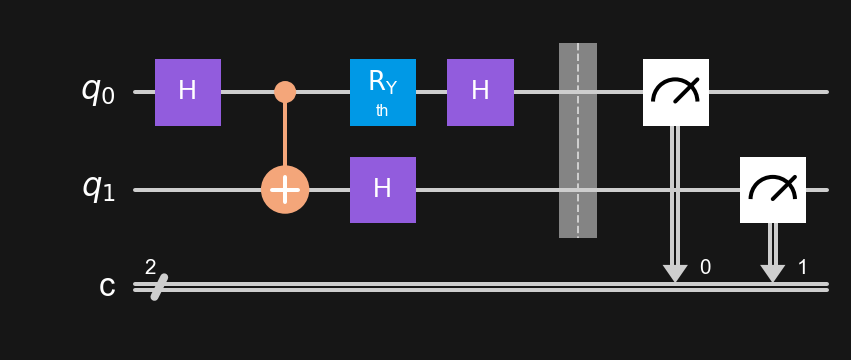

In [197]:
chsh_circuits[3].draw('mpl')

## Parameterized circuits: Sampler and Estimator


As described above, we will evaluate the circuits over different phases for the first qubit's measurement base:

In [193]:
number_of_phases = 50
phases = np.linspace(0, 2*np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

### Sampler

Here we call the `Sampler` in the form of a Python Context Manager:

# <font color='red'>!</font>

In [73]:
chsh_results_sim = []
chsh_results_exp = []
for chsh_circ in chsh_circuits:
    qc = chsh_circ
    # Simulator
    with Sampler(circuits=[qc], service=service, options={ "backend": backend_sim }) as sampler:
        param_results = sampler(circuit_indices=[0]*len(phases), parameter_values=individual_phases)
        chsh_results_sim.append(param_results)

    # Real device
    with Sampler(circuits=[qc], service=service, options={ "backend": backend_exp }) as sampler:
        param_results = sampler(circuit_indices=[0]*len(phases), parameter_values=individual_phases)
        chsh_results_exp.append(param_results)

In [194]:
chsh_results_sim

[SamplerResult(quasi_dists=[{'00': 0.4912109375, '11': 0.5087890625}, {'11': 0.529296875, '00': 0.470703125}, {'01': 0.0068359375, '11': 0.478515625, '10': 0.0078125, '00': 0.5068359375}, {'01': 0.017578125, '11': 0.4892578125, '10': 0.0185546875, '00': 0.474609375}, {'01': 0.02734375, '11': 0.47265625, '10': 0.03515625, '00': 0.46484375}, {'01': 0.0556640625, '10': 0.0634765625, '00': 0.4208984375, '11': 0.4599609375}, {'11': 0.4619140625, '10': 0.0595703125, '00': 0.4150390625, '01': 0.0634765625}, {'01': 0.0947265625, '10': 0.076171875, '00': 0.404296875, '11': 0.4248046875}, {'01': 0.138671875, '11': 0.3818359375, '10': 0.099609375, '00': 0.3798828125}, {'01': 0.142578125, '10': 0.16796875, '00': 0.3388671875, '11': 0.3505859375}, {'11': 0.3134765625, '01': 0.1748046875, '00': 0.328125, '10': 0.18359375}, {'01': 0.21484375, '00': 0.275390625, '10': 0.2392578125, '11': 0.2705078125}, {'11': 0.27734375, '00': 0.2529296875, '10': 0.2314453125, '01': 0.23828125}, {'11': 0.1982421875, '

After running the circuits, we need to build the CHSH witness functions. We first build the quantities $\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$, by looking at the parity of the outcomes for the four families of circuits we built (two measurement bases for each of the two qubits). Then we use those quantities to build the witness functions as defined above.

In [144]:
chsh_sim = []
chsh_exp = []

for chsh_result_sim in chsh_results_sim:
    
    obs_0 = [dist.get('00', 0) for dist in chsh_result_sim.quasi_dists]
    obs_1 = [dist.get('01', 0) for dist in chsh_result_sim.quasi_dists]
    obs_2 = [dist.get('10', 0) for dist in chsh_result_sim.quasi_dists]
    obs_3 = [dist.get('11', 0) for dist in chsh_result_sim.quasi_dists]
    
    chsh_sim.append([i-j-k+l for i,j,k,l in zip(obs_0,obs_1,obs_2,obs_3)])
    
for chsh_result_exp in chsh_results_exp:
    
    obs_0 = [dist.get('00', 0) for dist in chsh_result_exp.quasi_dists]
    obs_1 = [dist.get('01', 0) for dist in chsh_result_exp.quasi_dists]
    obs_2 = [dist.get('10', 0) for dist in chsh_result_exp.quasi_dists]
    obs_3 = [dist.get('11', 0) for dist in chsh_result_exp.quasi_dists]
    
    chsh_exp.append([i-j-k+l for i,j,k,l in zip(obs_0,obs_1,obs_2,obs_3)])
    
AB_sim = chsh_sim[0]
Ab_sim = chsh_sim[1]
aB_sim = chsh_sim[2]
ab_sim = chsh_sim[3]

AB_exp = chsh_exp[0]
Ab_exp = chsh_exp[1]
aB_exp = chsh_exp[2]
ab_exp = chsh_exp[3]
   
chsh1_sim = [i-j+k+l for i,j,k,l in zip(AB_sim,Ab_sim,aB_sim,ab_sim)]
chsh2_sim = [i+j-k+l for i,j,k,l in zip(AB_sim,Ab_sim,aB_sim,ab_sim)]

chsh1_exp = [i-j+k+l for i,j,k,l in zip(AB_exp,Ab_exp,aB_exp,ab_exp)]
chsh2_exp = [i+j-k+l for i,j,k,l in zip(AB_exp,Ab_exp,aB_exp,ab_exp)]
    


Now let's plot the results. First, we define some figure properties:

In [77]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          'figure.figsize': (10, 6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)

Then make the plot:

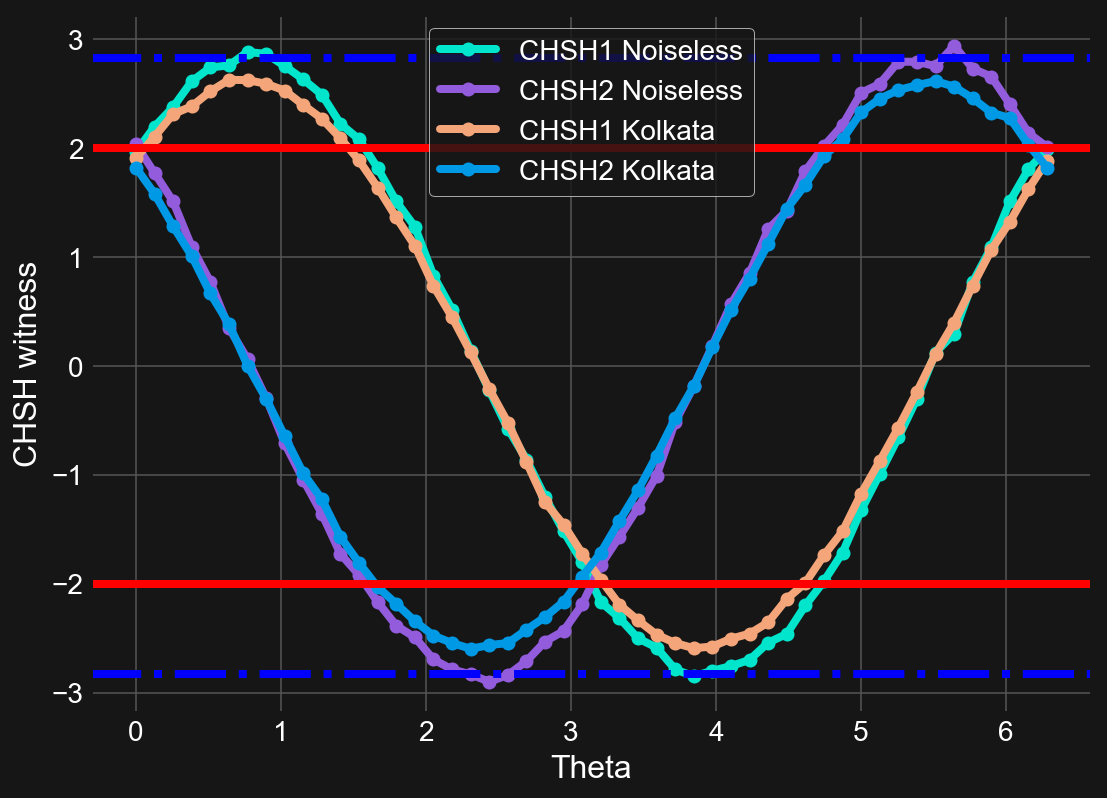

In [198]:
# fig = plt.figure(figsize=(10, 6))

# ax1 = fig.add_axes([0, 0, 1, 1])

plt.plot(phases, chsh1_sim, 'o-', label='CHSH1 Noiseless')
plt.plot(phases, chsh2_sim, 'o-', label='CHSH2 Noiseless')
plt.plot(phases, chsh1_exp, 'o-', label='CHSH1 Kolkata')
plt.plot(phases, chsh2_exp, 'o-', label='CHSH2 Kolkata')
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()

In the figure above, the red lines delimit the classical bound and the dash-dotted blue lines delimit the quantum bound. We indeed observe a violation of the $CHSH$ inequality in our real device!

### Estimator

The `Estimator` primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of expectation values. For maximum generalization, the `Estimator` primitive requires circuits with no measurements:

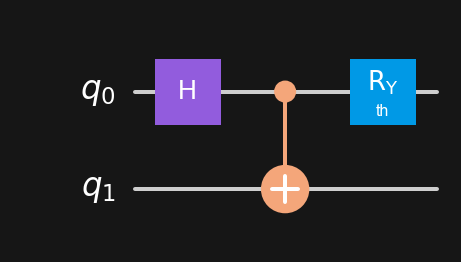

In [199]:
chsh_circuits_no_meas = QuantumCircuit(2)
chsh_circuits_no_meas.h(0)
chsh_circuits_no_meas.cx(0, 1)
chsh_circuits_no_meas.ry(th, 0)
chsh_circuits_no_meas.draw('mpl')

Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.

**Important** - This currently works for Pauli operators only.  Also, because there are no measurements from which to infer the number of qubits in the observable, one must pad the observable with identity (`I`) operators. 

# <font color='red'>!</font>

In [80]:
ops = ['ZZ','ZX','XZ','XX'] # Zeroth qubit is farthest to the right
chsh_est_sim = []
chsh_est_exp = []

for op in ops:
    # Simulator
    with Estimator(circuits=[chsh_circuits_no_meas], observables=[op],
                   service=service, options={ "backend": backend_sim }) as estimator:
        est_result = estimator(circuit_indices=[0]*len(phases),
                           observable_indices=[0]*len(phases),
                           parameter_values=individual_phases)
        chsh_est_sim.append(est_result)
        
    # Real device
    with Estimator(circuits=[chsh_circuits_no_meas], observables=[op],
                   service=service, options={ "backend": backend_exp }) as estimator:
        est_result = estimator(circuit_indices=[0]*len(phases),
                           observable_indices=[0]*len(phases),
                           parameter_values=individual_phases)
        chsh_est_exp.append(est_result)
        
chsh1_est_sim = chsh_est_sim[0].values - chsh_est_sim[1].values + chsh_est_sim[2].values + chsh_est_sim[3].values
chsh2_est_sim = chsh_est_sim[0].values + chsh_est_sim[1].values - chsh_est_sim[2].values + chsh_est_sim[3].values

chsh1_est_exp = chsh_est_exp[0].values - chsh_est_exp[1].values + chsh_est_exp[2].values + chsh_est_exp[3].values
chsh2_est_exp = chsh_est_exp[0].values + chsh_est_exp[1].values - chsh_est_exp[2].values + chsh_est_exp[3].values

Note that now we do not have to build the observables ourselves because they are returned to us! The computed expectation values are given in `result.values`. What comes back is a very small payload of data.

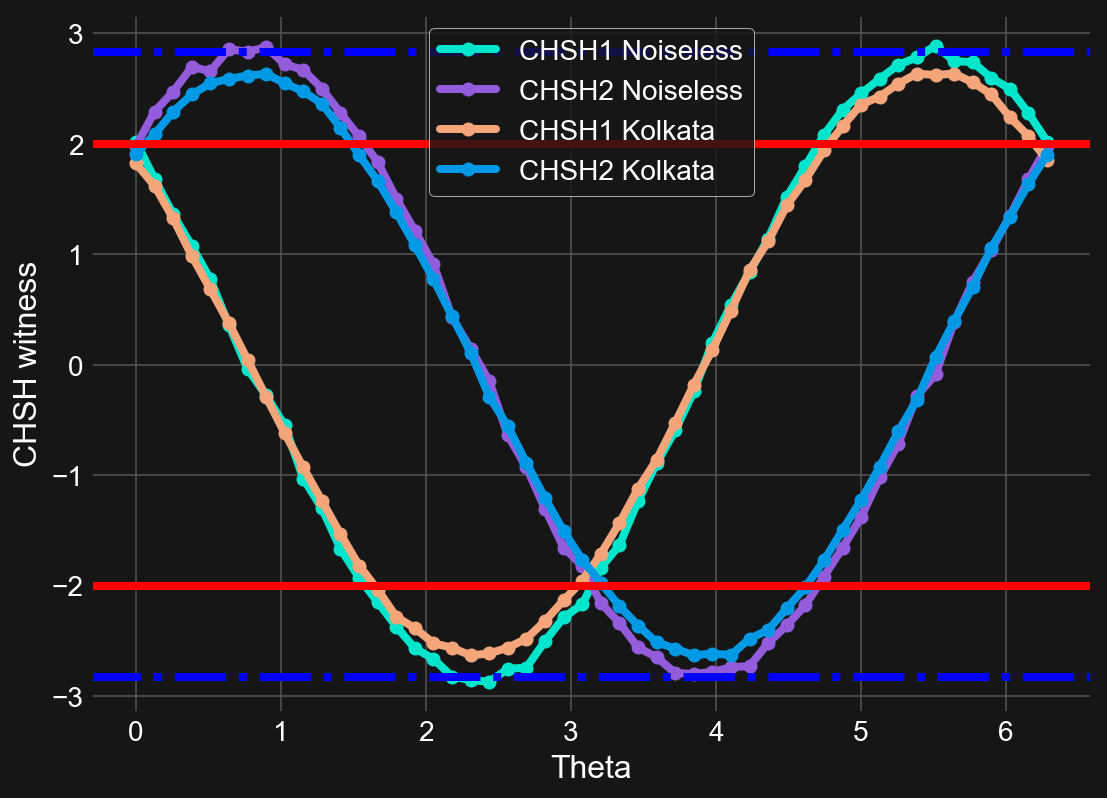

In [200]:
plt.plot(phases, chsh1_est_sim, 'o-', label='CHSH1 Noiseless')
plt.plot(phases, chsh2_est_sim, 'o-', label='CHSH2 Noiseless')
plt.plot(phases, chsh1_est_exp, 'o-', label='CHSH1 Kolkata')
plt.plot(phases, chsh2_est_exp, 'o-', label='CHSH2 Kolkata')
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend()